# Time Series Classification Demo

In [7]:
using Plots

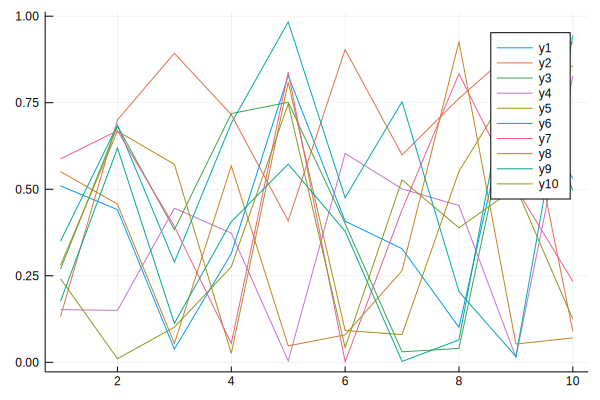

In [8]:
plot(rand(10,10))

## Let's add workers for parallel processing

In [9]:
using Distributed
nprocs()==1 && addprocs()
nworkers()

8

## Load TSML Modules and other Dependencies

In [10]:
@everywhere using TSML, TSMLextra, Plots
@everywhere using TSML.TSMLTypes
@everywhere using TSML: TSClassifier
@everywhere using TSML.TSClassifiers.FileStats
@everywhere using TSML.EnsembleMethods
@everywhere using TSML.DecisionTreeLearners
@everywhere using TSML.Utils
@everywhere using TSMLextra.CaretLearners
@everywhere using TSMLextra.SKLearners
@everywhere using TSML.MLBaseWrapper

@everywhere using DataFrames
@everywhere using Random
@everywhere using Statistics
@everywhere using StatsBase: iqr
@everywhere using RDatasets
ENV["COLUMNS"]=1000; # for dataframe column size

## Initialize ML models from Julia, Caret, and Scikitlearn

In [14]:
# Caret ML
@everywhere caret_svmlinear = CaretLearner(Dict(:learner=>"svmLinear"))
@everywhere caret_treebag = CaretLearner(Dict(:learner=>"treebag"))
@everywhere caret_rpart = CaretLearner(Dict(:learner=>"rpart"))
@everywhere caret_rf = CaretLearner(Dict(:learner=>"rf"))

# ScikitLearn ML
@everywhere sk_ridge = SKLearner(Dict(:learner=>"RidgeClassifier"))
@everywhere sk_sgd = SKLearner(Dict(:learner=>"SGDClassifier"))
@everywhere sk_knn = SKLearner(Dict(:learner=>"KNeighborsClassifier"))
@everywhere sk_gb = SKLearner(Dict(:learner=>"GradientBoostingClassifier",:impl_args=>Dict(:n_estimators=>10)))
@everywhere sk_extratree = SKLearner(Dict(:learner=>"ExtraTreesClassifier",:impl_args=>Dict(:n_estimators=>10)))
@everywhere sk_rf = SKLearner(Dict(:learner=>"RandomForestClassifier",:impl_args=>Dict(:n_estimators=>10)))

# Julia ML
@everywhere jrf = RandomForest(Dict(:impl_args=>Dict(:num_trees=>300)))
@everywhere jpt = PrunedTree()
@everywhere jada = Adaboost()

# Julia Ensembles
@everywhere jvote_ens=VoteEnsemble(Dict(:learners=>[jrf,jpt,sk_gb,sk_extratree,sk_rf]))
@everywhere jstack_ens=StackEnsemble(Dict(:learners=>[jrf,jpt,sk_gb,sk_extratree,sk_rf]))
@everywhere jbest_ens=BestLearner(Dict(:learners=>[jrf,sk_gb,sk_rf]))
@everywhere jsuper_ens=VoteEnsemble(Dict(:learners=>[jvote_ens,jstack_ens,jbest_ens,sk_rf,sk_gb]))

## Functions for feature extraction and prediction

In [12]:
@everywhere function predict(learner,data,train_ind,test_ind)
    features = convert(Matrix,data[:, 1:(end-1)])
    labels = convert(Array,data[:, end])
    # Create pipeline
     pipeline = Pipeline(
       Dict(
         :transformers => [
           OneHotEncoder(), # Encodes nominal features into numeric
           Imputer(), # Imputes NA values
           StandardScaler(),
           learner # Predicts labels on instances
         ]
       )
     )
     # Train
     fit!(pipeline, features[train_ind, :], labels[train_ind]);
     # Predict
     predictions = transform!(pipeline, features[test_ind, :]);
     # Assess predictions
     result = score(:accuracy, labels[test_ind], predictions)
     return result
end

## Data processing and feature extraction

In [ ]:
@everywhere function extract_features_from_timeseries(datadir)
  println("*** Extracting features ***")
  mdata = getstats(datadir)
  mdata[!,:dtype] = mdata[!,:dtype] |> Array{String}
  return mdata[!,3:(end-1)]
end

datadir = joinpath("data/")
tsdata = extract_features_from_timeseries(datadir)
first(tsdata,5)

## Run in parallel all models in different trials

In [28]:
function parallelmodel(learners::Dict,data::DataFrame;trials=5)
    models=collect(keys(learners))
    ctable=@distributed (vcat) for i=1:trials
        # Split into training and test sets
        Random.seed!(3i)
        (train_ind, test_ind) = holdout(size(data, 1), 0.20)
        acc=@distributed (vcat) for model in models
            res=predict(learners[model],data,train_ind,test_ind)
            println("trial ",i,", ",model," => ",round(res))
            [model res i]
        end
        acc
    end
    df = ctable |> DataFrame
    rename!(df,:x1=>:model,:x2=>:acc,:x3=>:trial)
    gp=by(df,:model) do x
       DataFrame(mean=mean(x.acc),std=std(x.acc),n=length(x.acc)) 
    end
    sort!(gp,:mean,rev=true)
    return gp
end

parallelmodel (generic function with 1 method)

In [29]:
learners=Dict(
      :jvote_ens=>jvote_ens,:jstack_ens=>jstack_ens,:jbest_ens=>jbest_ens,
      :jrf => jrf,:jada=>jada,:jsuper_ens=>jsuper_ens,#:crt_rpart=>caret_rpart,
      :crt_svmlinear=>caret_svmlinear,:crt_treebag=>caret_treebag,#:crt_rf=>caret_rf, 
      :skl_knn=>sk_knn,:skl_gb=>sk_gb,:skl_extratree=>sk_extratree,
      :sk_rf => sk_rf
);

df = parallelmodel(learners,tsdata;trials=3)

      From worker 3:	trial 1, skl_extratree => 100.0
      From worker 2:	trial 3, skl_extratree => 100.0
      From worker 5:	trial 3, skl_gb => 50.0
      From worker 5:	trial 3, jada => 50.0
      From worker 5:	trial 2, skl_gb => 75.0
      From worker 5:	trial 2, jada => 50.0
      From worker 5:	trial 1, skl_gb => 75.0
      From worker 5:	trial 1, jada => 25.0
      From worker 9:	trial 3, skl_knn => 50.0
      From worker 9:	trial 2, skl_knn => 75.0
      From worker 9:	trial 1, skl_knn => 75.0
      From worker 8:	trial 3, sk_rf => 50.0
      From worker 8:	trial 2, sk_rf => 75.0
      From worker 8:	trial 1, sk_rf => 75.0
      From worker 4:	trial 3, jrf => 25.0
      From worker 2:	trial 3, crt_treebag => 50.0
      From worker 2:	trial 2, skl_extratree => 100.0
      From worker 3:	trial 1, crt_treebag => 100.0
      From worker 3:	trial 2, jrf => 100.0
      From worker 6:	trial 3, crt_svmlinear => 75.0
      From worker 6:	trial 2, crt_svmlinear => 75.0
      From worker

,model,mean,std,n
,Any,Float64,Float64,Int64
1,skl_extratree,100.0,0.0,3
2,crt_treebag,83.3333,28.8675,3
3,jvote_ens,83.3333,14.4338,3
4,crt_svmlinear,83.3333,14.4338,3
5,jbest_ens,75.0,43.3013,3
6,jsuper_ens,75.0,43.3013,3
7,jrf,66.6667,38.1881,3
8,skl_gb,66.6667,14.4338,3
9,sk_rf,66.6667,14.4338,3
